In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

In [3]:
model_name = 'google/flan-t5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [34]:
def get_response_and_scores(prompt, reference):
    # Encode & Decode
    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length


In [35]:
new_prompt = 'Describe the influence of transformer architecture in AI'

In [36]:
reference_text = 'Artificial Intelligence, with its ability to analyze massive data sets and learn from patterns, has revolutionized industries like healthcare, finance, and transportation, by driving efficiencies and enabling new services, while also raising ethical considerations around privacy and job displacement.'
response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.027778   0.083333  0.041667
1  ROUGE-2  0.000000   0.000000  0.000000
2  ROUGE-L  0.027778   0.083333  0.041667

Response: AI has a profound impact on the way we think about the world
Perplexity: 1.6177455186843872
MTLD: 47.320000000000036
Response length: 60


In [37]:
model.config.output_attentions = True

def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.colorbar(cax)
    plt.show()


In [38]:
response = response.split(".")[0] + "."

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/1010400705.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/1010400705.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


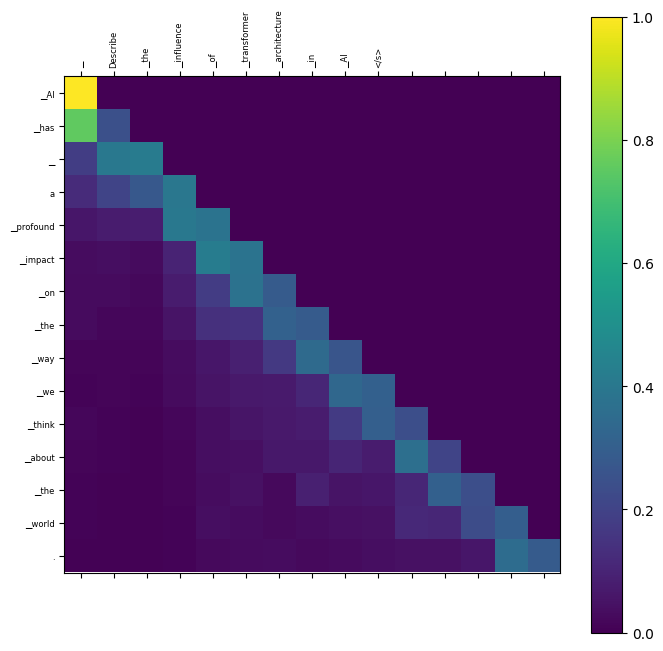

In [39]:
visualize_attention(new_prompt, response)

In [40]:
def visualize_attention_per_head(prompt, response):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")

    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    
    # Determine the grid size: square root of number of heads
    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axs to easily loop through

    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(tgt_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(tgt_tokens, fontsize=6)
        axs[head].set_title(f'Head {head+1} (RP)')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('attention_heads_rp_t5.png', dpi=300)


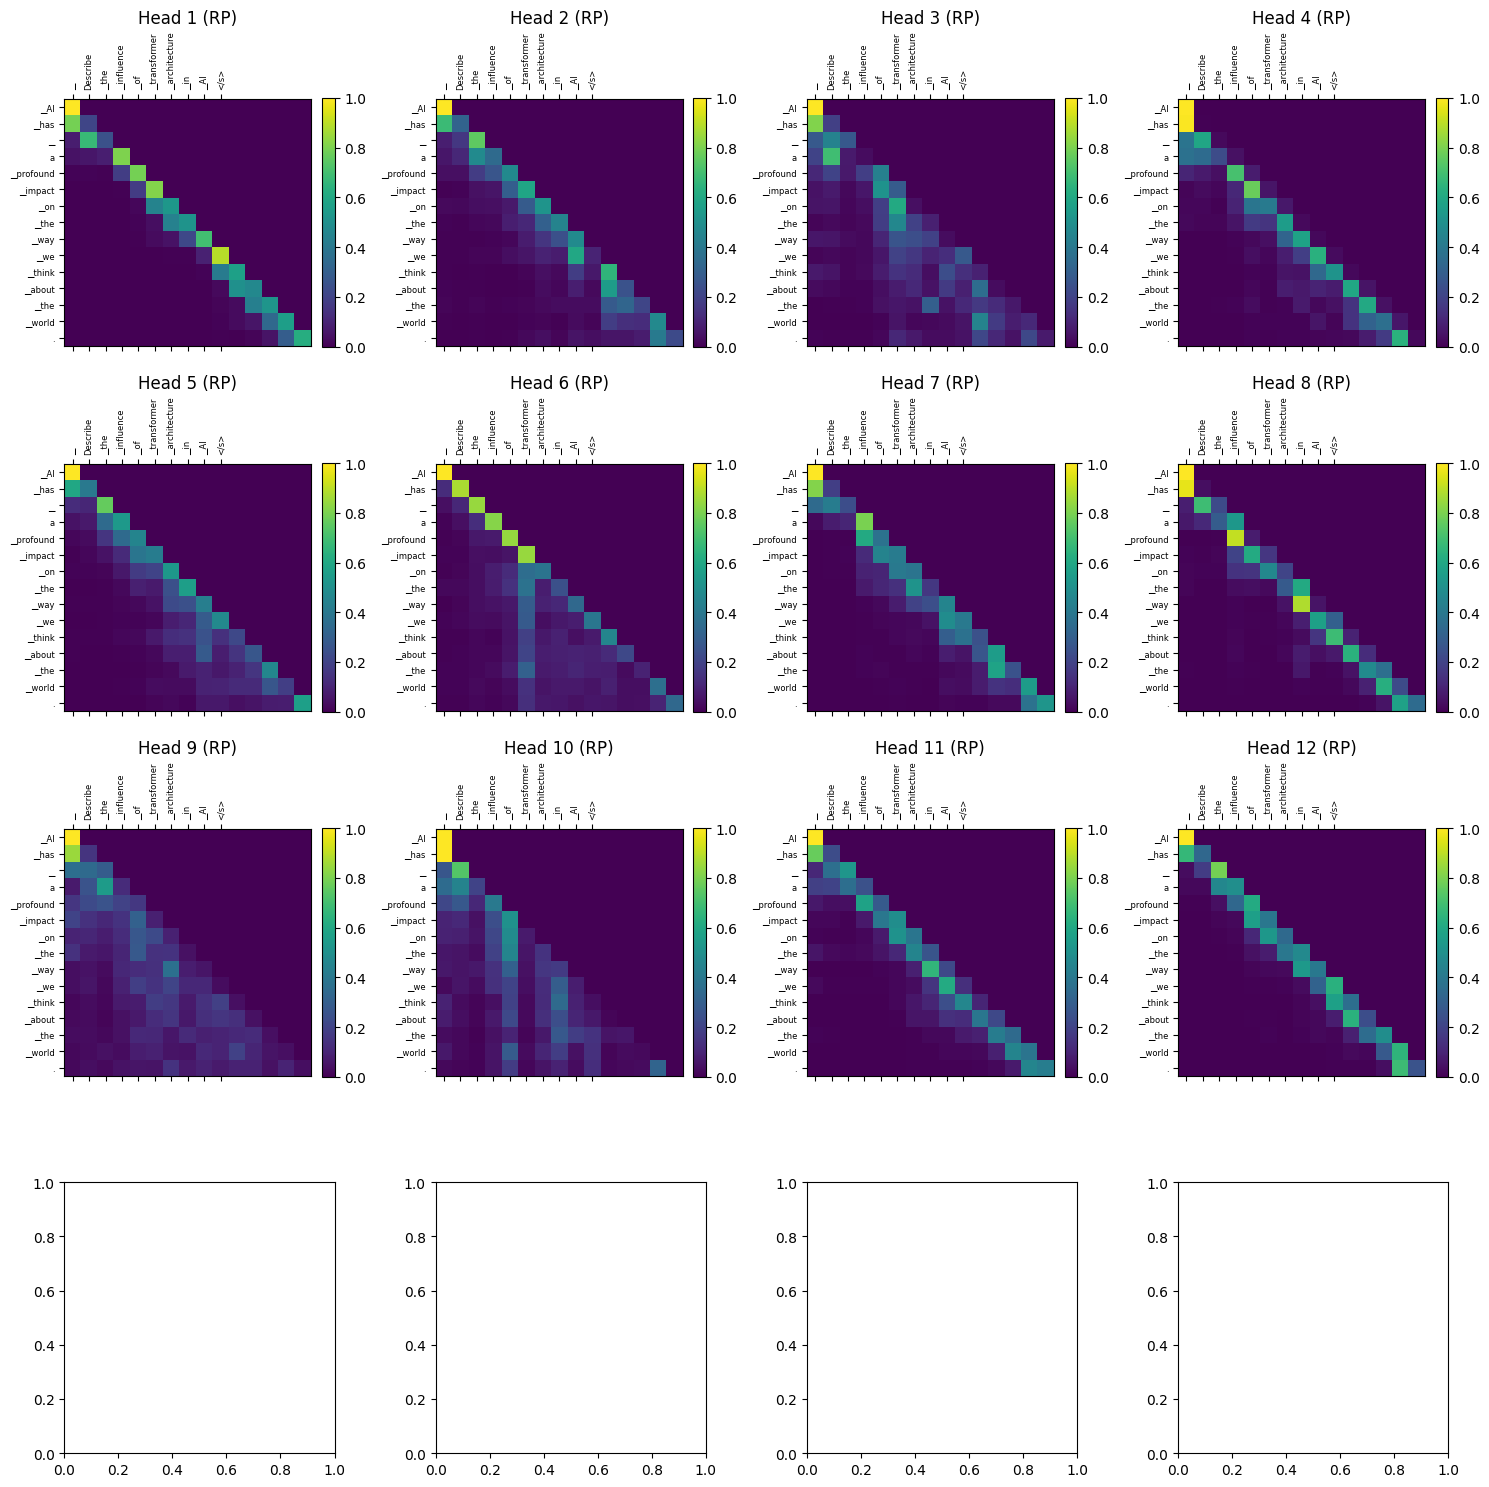

In [41]:
visualize_attention_per_head(new_prompt, response)